<a href="https://colab.research.google.com/github/tommybebe/til/blob/master/notebooks/machine_learning_for_anomaly_detection_and_condition_monitoring.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://towardsdatascience.com/machine-learning-for-anomaly-detection-and-condition-monitoring-d4614e7de770

### get data file
- file location : https://ti.arc.nasa.gov/c/3/
- directly download from server with curl in colab doesn't work 
- downloaded file from browser and saved file in drive.

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /gdrive


In [2]:
!mkdir 2nd_test
!7za e /gdrive/'My Drive'/study/anormaly/nasa_bearing.7z
!unrar e 2nd_test.rar 2nd_test


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /gdrive/My Drive/study/anormaly/                                          1 file, 1075320408 bytes (1026 MiB)

Extracting archive: /gdrive/My Drive/study/anormaly/nasa_bearing.7z
--
Path = /gdrive/My Drive/study/anormaly/nasa_bearing.7z
Type = 7z
Physical Size = 1075320408
Headers Size = 279
Method = LZMA:24
Solid = +
Blocks = 1

  0%      0% - 1st_test.rar                     1% - 1st_test.rar                     2% - 1st_test.rar                     3% - 1st_test.rar                     4% - 1st_test.rar

### setting

In [5]:
# Common imports
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout
from keras.layers.core import Dense 
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

Using TensorFlow backend.


In [6]:
data_dir = '2nd_test'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    print(filename)
    dataset=pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)

merged_data.columns = ['Bearing 1','Bearing 2','Bearing 3','Bearing 4']

2004.02.17.17.12.39
2004.02.13.09.32.39
2004.02.14.05.52.39
2004.02.18.13.52.39
2004.02.12.12.02.39
2004.02.15.10.42.39
2004.02.13.15.02.39
2004.02.15.16.42.39
2004.02.14.02.32.39
2004.02.13.00.22.39
2004.02.16.20.22.39
2004.02.14.11.32.39
2004.02.15.13.02.39
2004.02.18.10.42.39
2004.02.12.13.52.39
2004.02.13.07.42.39
2004.02.19.03.42.39
2004.02.12.15.22.39
2004.02.14.16.02.39
2004.02.14.11.12.39
2004.02.13.01.32.39
2004.02.12.21.42.39
2004.02.16.12.02.39
2004.02.14.04.52.39
2004.02.14.03.52.39
2004.02.16.22.52.39
2004.02.17.16.52.39
2004.02.14.20.22.39
2004.02.15.19.52.39
2004.02.18.06.02.39
2004.02.13.18.02.39
2004.02.17.06.42.39
2004.02.15.07.02.39
2004.02.13.02.12.39
2004.02.14.10.52.39
2004.02.18.00.22.39
2004.02.15.00.02.39
2004.02.14.15.32.39
2004.02.19.05.22.39
2004.02.16.10.32.39
2004.02.17.19.32.39
2004.02.17.18.12.39
2004.02.18.18.52.39
2004.02.13.08.02.39
2004.02.18.18.22.39
2004.02.16.21.22.39
2004.02.15.02.02.39
2004.02.18.13.32.39
2004.02.17.12.02.39
2004.02.16.05.22.39


In [8]:
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('merged_dataset_BearingTest_2.csv')
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


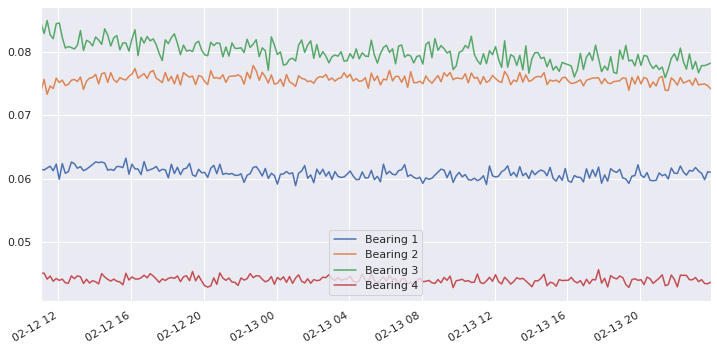

In [9]:
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]
dataset_train.plot(figsize = (12,6))

In [0]:
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

### PCA type model for anomaly detection

In [0]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [0]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [0]:
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [0]:
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [0]:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [0]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [0]:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [0]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)
mean_distr = data_train.mean(axis=0)

dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = True)

(0.0, 15)

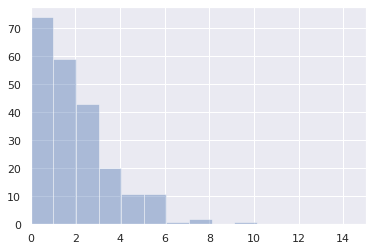

In [27]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

Text(0.5, 0, 'Mahalanobis dist')

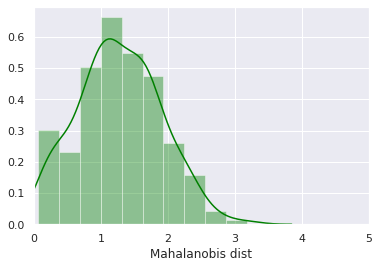

In [29]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [30]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


In [0]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
anomaly_alldata.to_csv('Anomaly_distance.csv')

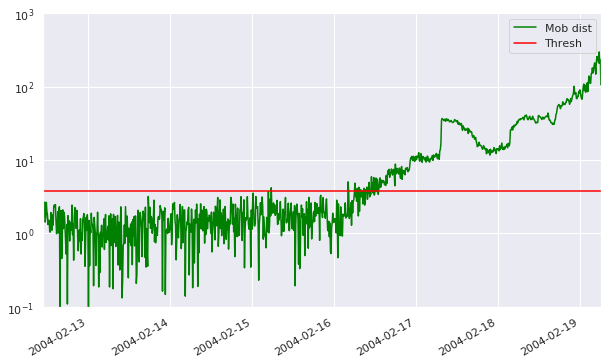

In [43]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])

### Other approach: Autoencoder model for anomaly detection


In [44]:
seed(10)
set_random_seed(10)
act_func = 'elu'

# Input layer:
model=Sequential()
# First hidden layer, connected to input vector X. 
model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform',
                kernel_regularizer=regularizers.l2(0.0),
                input_shape=(X_train.shape[1],)
               )
         )

model.add(Dense(2,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(10,activation=act_func,
                kernel_initializer='glorot_uniform'))

model.add(Dense(X_train.shape[1],
                kernel_initializer='glorot_uniform'))

model.compile(loss='mse',optimizer='adam')

# Train model for 100 epochs, batch size of 10: 
NUM_EPOCHS=100
BATCH_SIZE=10

In [45]:
history=model.fit(np.array(X_train),np.array(X_train),
                  batch_size=BATCH_SIZE, 
                  epochs=NUM_EPOCHS,
                  validation_split=0.05,
                  verbose = 1)




Train on 210 samples, validate on 12 samples
Epoch 1/100





210/210 [==============================] - 1s 4ms/step - loss: 0.2798 - val_loss: 0.1874
Epoch 2/100
210/210 [==============================] - 0s 171us/step - loss: 0.1487 - val_loss: 0.0883
Epoch 3/100
210/210 [==============================] - 0s 162us/step - loss: 0.0791 - val_loss: 0.0471
Epoch 4/100
210/210 [==============================] - 0s 157us/step - loss: 0.0484 - val_loss: 0.0346
Epoch 5/100
210/210 [==============================] - 0s 152us/step - loss: 0.0374 - val_loss: 0.0320
Epoch 6/100
210/210 [==============================] - 0s 164us/step - loss: 0.0344 - val_loss: 0.0339
Epoch 7/100
210/210 [==============================] - 0s 137us/step - loss: 0.0334 - val_loss: 0.0341
Epoch 8/100
210/210 [==============================] - 0s 141us/step - loss: 0.0328 - val_loss: 0.0332
Epoch 9/100
210/210 [==============================] - 0s 155us/step - loss: 0.0323 - val_loss: 0.0338
Epoch 10/100
210/210 [

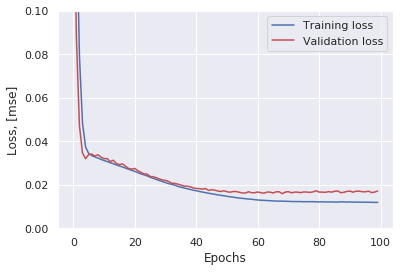

In [46]:
plt.plot(history.history['loss'],
         'b',
         label='Training loss')
plt.plot(history.history['val_loss'],
         'r',
         label='Validation loss')
plt.legend(loc='upper right')
plt.xlabel('Epochs')
plt.ylabel('Loss, [mse]')
plt.ylim([0,.1])
plt.show()

(0.0, 0.5)

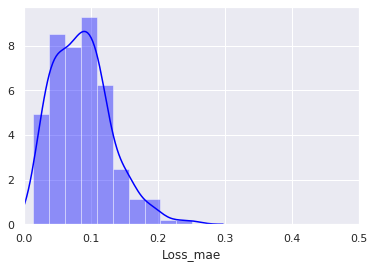

In [47]:
X_pred = model.predict(np.array(X_train))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_train.columns)
X_pred.index = X_train.index

scored = pd.DataFrame(index=X_train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure()
sns.distplot(scored['Loss_mae'],
             bins = 10, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

In [48]:
X_pred = model.predict(np.array(X_test))
X_pred = pd.DataFrame(X_pred, 
                      columns=X_test.columns)
X_pred.index = X_test.index

scored = pd.DataFrame(index=X_test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.3
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-13 23:52:39,0.132354,0.3,False
2004-02-14 00:02:39,0.117414,0.3,False
2004-02-14 00:12:39,0.034864,0.3,False
2004-02-14 00:22:39,0.143616,0.3,False
2004-02-14 00:32:39,0.071510,0.3,False


In [0]:
X_pred_train = model.predict(np.array(X_train))
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=X_train.columns)
X_pred_train.index = X_train.index

scored_train = pd.DataFrame(index=X_train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.3
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

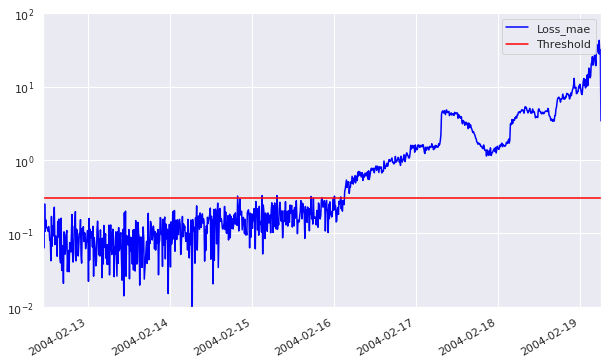

In [52]:
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])